# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°3 - Predicción lineal
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

En este trabajo se aplicará el concepto de predicción lineal a señales de voz.

# TODO
* -----Limpiar helper
* -----Grabar las cosas posta
* -----Sacar conclusiones
* Cambiar FFT por periodogram (welch) en donde corresponda
* -----Actualizar color en todos los gráficos
* Corregir títulos de figuras en plot_spectrograms
* -----Agregar ruido blanco al /sh/
* -NO--Padear speech
* Agregar plt text a las vlines.
* Chequear desarrollo matemático.
* ¿Hace falta el gráfico de la autocorrelación de las señales de error para calcular el filtro AR?
* Chequear valores de codos.
* Conclusiones del punto 4. agregar números?
* En periodogramas, está bien comparar con la **FFT** de la señal?

# 1. Obtención de las grabaciones
En primer lugar, se graban los dos sonidos a utilizar en el trabajo. Estos son una grabación sostenida del fonema /a/ y otra del fonema /sh/. Ambas frecuencias de muestreo fueron fijadas en $16kHz$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from helper import print_signal, plot_spectrograms, to_wav, forward_prediction_filter, get_forward_error
from scipy.linalg import solve_toeplitz
import scipy.signal as sps
from statsmodels.tsa.filters.filtertools import recursive_filter

## 1.1 Grabación de /a/

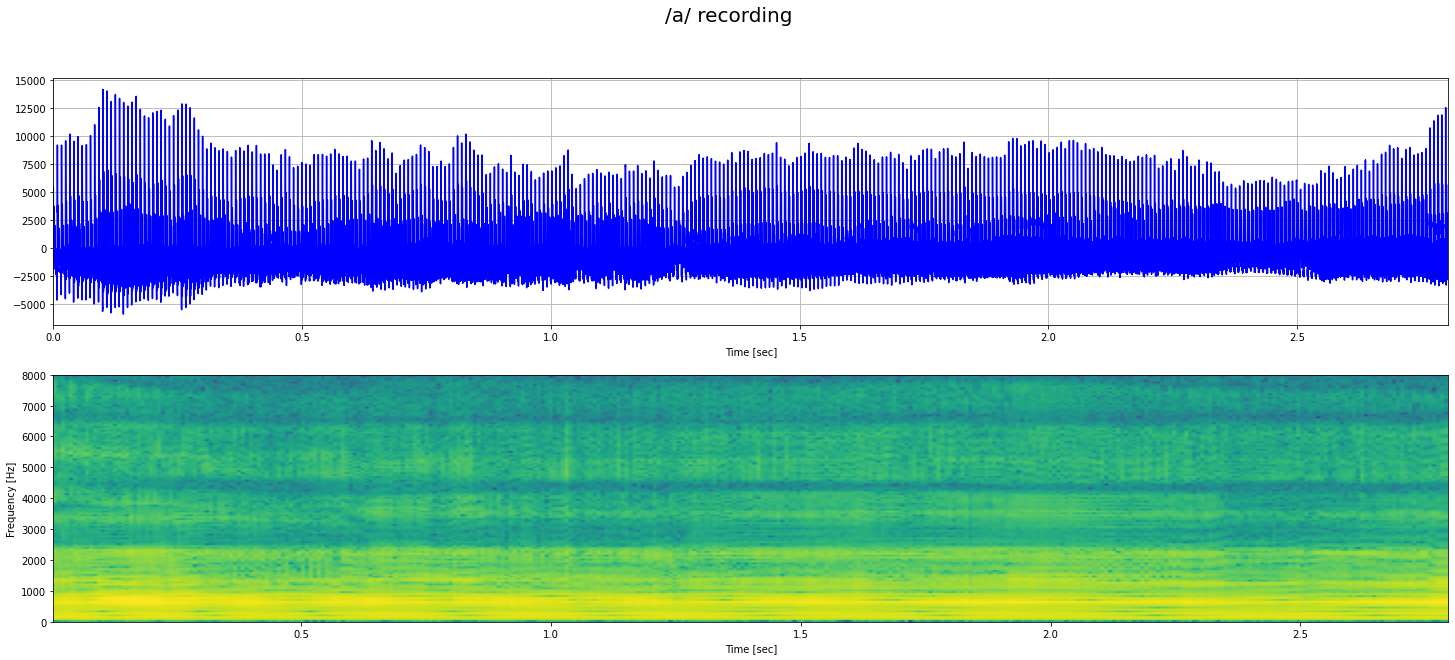

In [2]:
# /a/ sound
a_fs, a_sound = wavfile.read('../assets/a_sound.wav')

# Plot signal
print_signal(np.arange(len(a_sound)) / a_fs, a_sound, '/a/ recording', samplerate=a_fs, xlim=(0,len(a_sound)/a_fs))

In [3]:
print('/a/ original recording')
Audio('../assets/a_sound.wav')

/a/ original recording


## 1.2 Grabación de /sh/

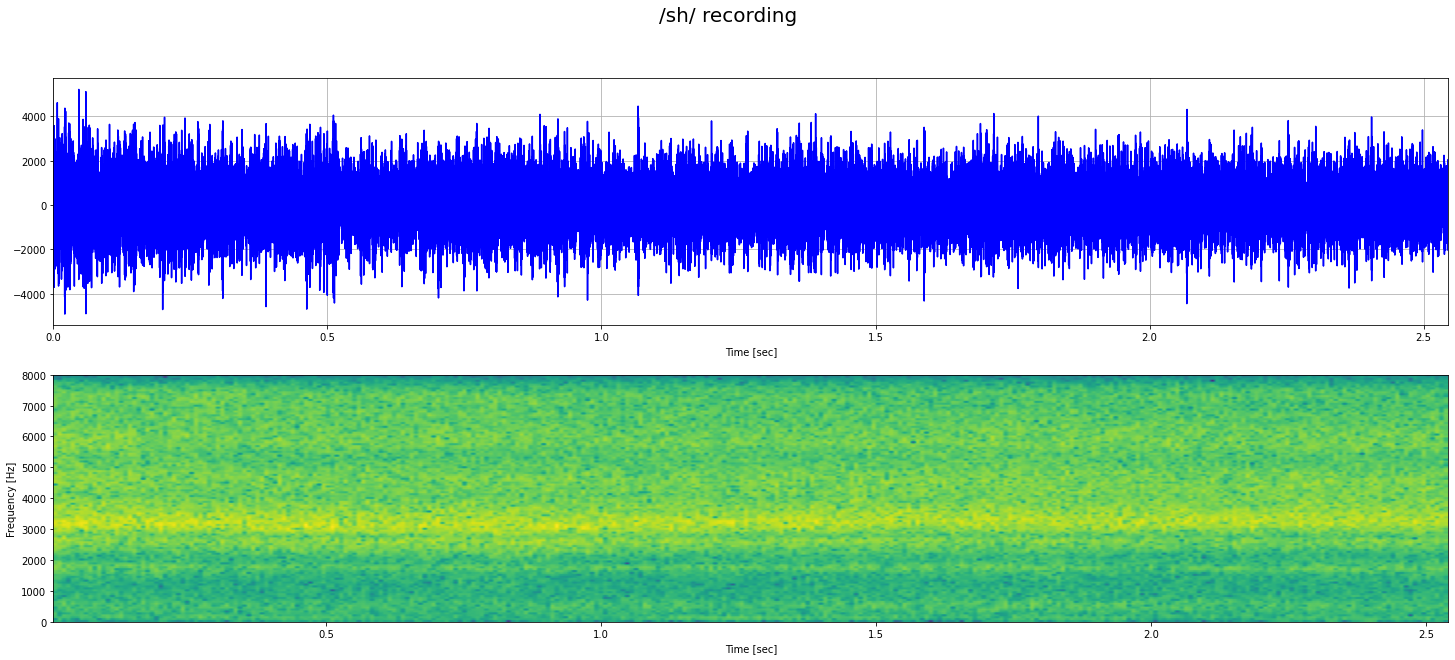

In [4]:
# /sh/ sound
sh_fs, sh_sound = wavfile.read('../assets/sh_sound.wav')

# Plot signal
print_signal(np.arange(len(sh_sound)) / sh_fs, sh_sound, '/sh/ recording', samplerate=sh_fs, xlim=(0,len(sh_sound)/sh_fs))

In [5]:
print('/sh/ original recording')
Audio('../assets/sh_sound.wav')

/sh/ original recording


# 2. Predicción forward
A continuación se realiza una predicción del tipo forward sobre cada una de las pistas de audio grabadas. Se realiza un barrido respecto del largo del filtro $M$, de forma tal de poder apreciar cómo varía el MSE mínimo $J_o$ al aumentar el orden.

En primer lugar, se resta la media a cada una de las señales para poder cumplir con la hipótesis de media nula. Además se normalizan las señales al rango $[-1,1]$ para simplificar el posterior análisis.

In [6]:
# Substract mean to signals
a_sound = a_sound - np.mean(a_sound)
sh_sound = sh_sound - np.mean(sh_sound)

# Normalize signals
a_norm = a_sound / np.iinfo(np.int16).max
sh_norm = sh_sound / np.iinfo(np.int16).max

Se supone a la señal localmente estacionaria. Luego se pueden aplicar las ecuaciones de predicción forward estacionarias.

In [7]:
orders = [i for i in range(1,400)]
errors = {'a':[], 'sh':[]}

for o in orders:
    # /a/ sound predictor
    _, e = forward_prediction_filter(a_norm, o)
    errors['a'].append(e)
    
    # /sh/ sound predictor
    _, e = forward_prediction_filter(sh_norm, o)
    errors['sh'].append(e)

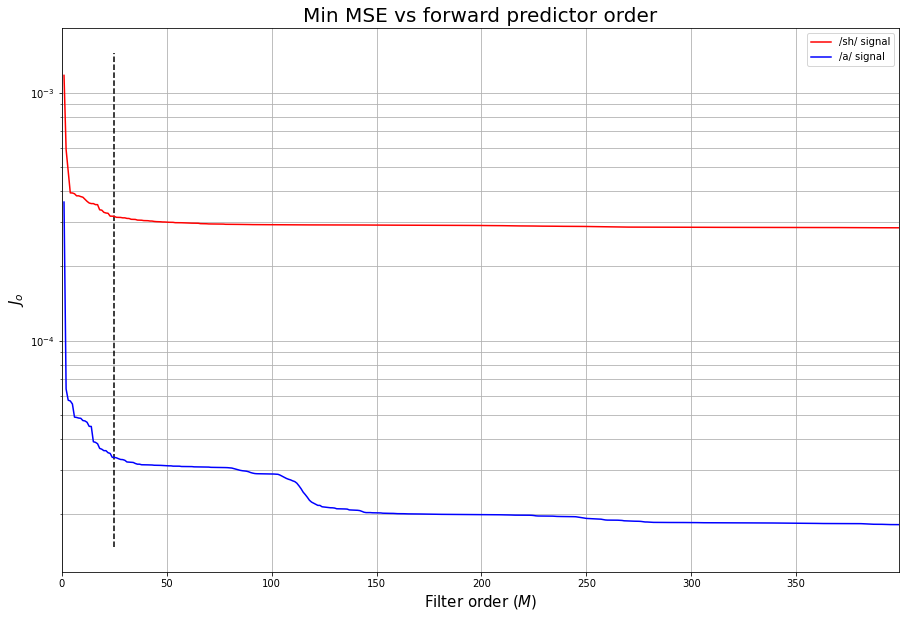

In [8]:
plt.figure(figsize=(15,10))
plt.xlim(0, np.max(orders))
plt.grid(which='both', axis='both')
plt.title('Min MSE vs forward predictor order', fontsize=20)
plt.xlabel('Filter order ($M$)', fontsize=15)
plt.ylabel('$J_o$', fontsize=15)
plt.semilogy(orders, errors['sh'], color='red', label='/sh/ signal')
plt.semilogy(orders, errors['a'], color='blue', label='/a/ signal')
plt.vlines(25,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.legend()
plt.show()

En el gráfico anterior se aprecia la evolución del error mínimo $J_o$ variando el orden $M$, para ambas grabaciones. 

Respecto de la grabación de /sh/, se observa que el error MSE mínimo disminuye considerablemente hasta alcanzar un valor asintótico a partir del orden $M=25$ aproximandamente. Este fenómeno se puede explicar observando la autocorrelación de la señal. Sabiendo que el filtro se basa en la correlación para poder realizar la predicción, luego si al aumentar el orden del filtro se incorporan muestras con una correlación débil o nula, no se estará aportando nueva información de predicción al filtro. Entonces, se produce el comportamiento asintótico del error que se aprecia en el gráfico mencionado. Para el caso de la señal /sh/, se puede considerar a la autocorrelación asintótica en cero a partir de un orden $M=25$.

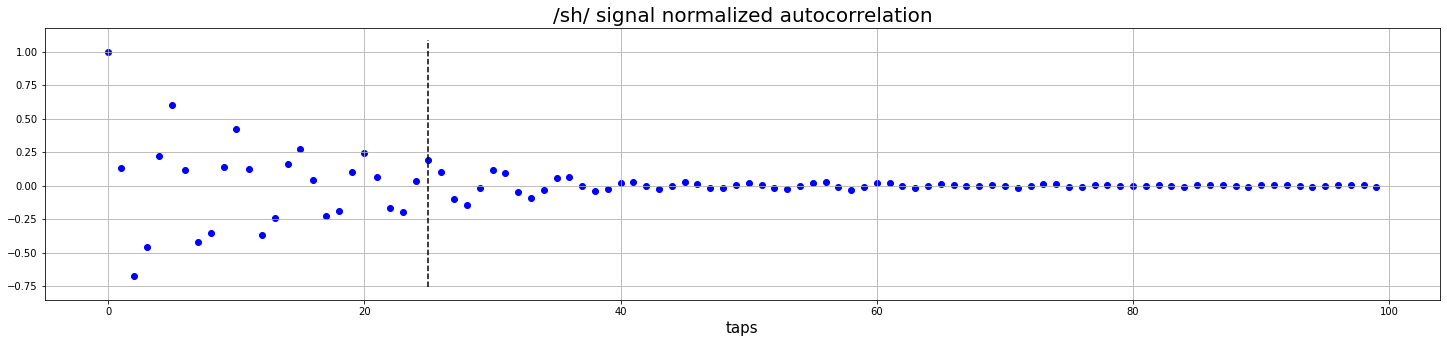

In [9]:
# Compute autocorrelation for /a/ signal.
sh_corr =  sps.correlate(sh_norm, sh_norm, method='fft', mode='same')[len(sh_norm)//2:] / (len(sh_norm))

# Normalize autocorrelation
sh_corr = sh_corr / sh_corr[0]

# PLot autocorrelation
plt.figure(figsize=(25,5))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(sh_corr[:100])), sh_corr[:100], color='blue')
plt.title('/sh/ signal normalized autocorrelation', fontsize=20)
plt.vlines(25,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.xlabel('taps', fontsize=15)
plt.show()

En relación a la señal /a/, se pueden apreciar dos codos en el gráfico de $J_o$ ($M_0=25$ y $M_1=135$). Esto nuevamente puede ser justificado observando la autocorrelación de la señal. 

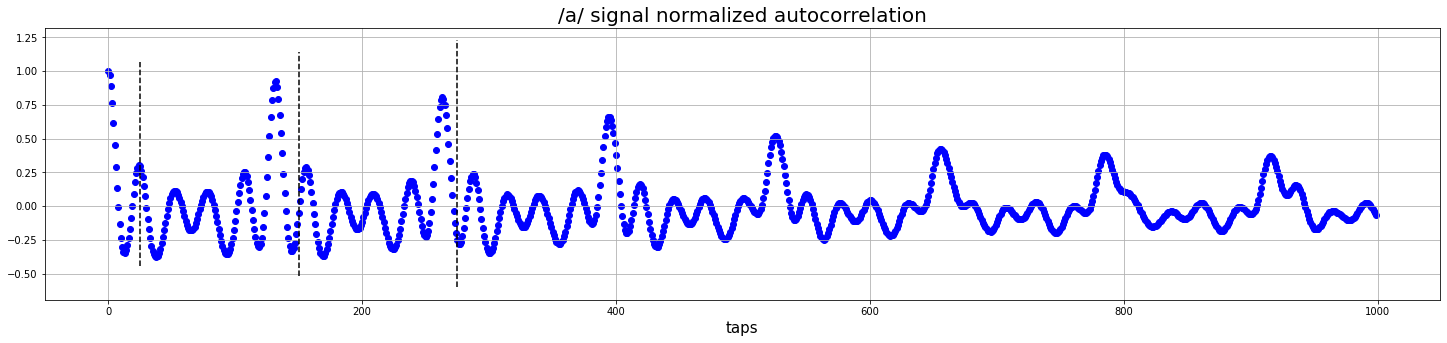

In [10]:
# Compute autocorrelation for /a/ signal.
a_corr =  sps.correlate(a_norm, a_norm, method='fft', mode='same')[len(a_norm)//2:] / (len(a_norm))

# Normalize autocorrelation
a_corr = a_corr[:1000] / a_corr[0]

# PLot autocorrelation
plt.figure(figsize=(25,5))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(a_corr)), a_corr, color='blue')
plt.title('/a/ signal normalized autocorrelation', fontsize=20)
plt.vlines(25,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.vlines(150,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.vlines(275,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.xlabel('taps', fontsize=15)
plt.show()

A diferencia de la señal /sh/, la autocorrelación de la señal /a/ presenta una componente periódica que se repite cada 135 muestras. Cada repetición se ve además atenuada en su nivel de correlación. La aparición de estos picos de autocorrelación hace que se forme el segundo codo, dado que al incorporar muestras en el entorno del pico se está agregando infdormación importante para el filtro al momento de predecir la próxima muestra. Dado que los picos se van atenuando, cada vez es menos notable la presencia de estos codos. Si en el gráfico de $J_o$ en función de $M$ se señala la recta $M=275$, se puede ver que existió otra caída abrupta en el nivel de error de la predicción. Volviendo al gráfico de la autocorrelación, nuevamente se aprecia que se incorporó otro pico.

In [11]:
a12, _ = forward_prediction_filter(a_norm, 12)
e12 = get_forward_error(a_norm, a12)

a175, _ = forward_prediction_filter(a_norm,175)
e175 = get_forward_error(a_norm, a175)

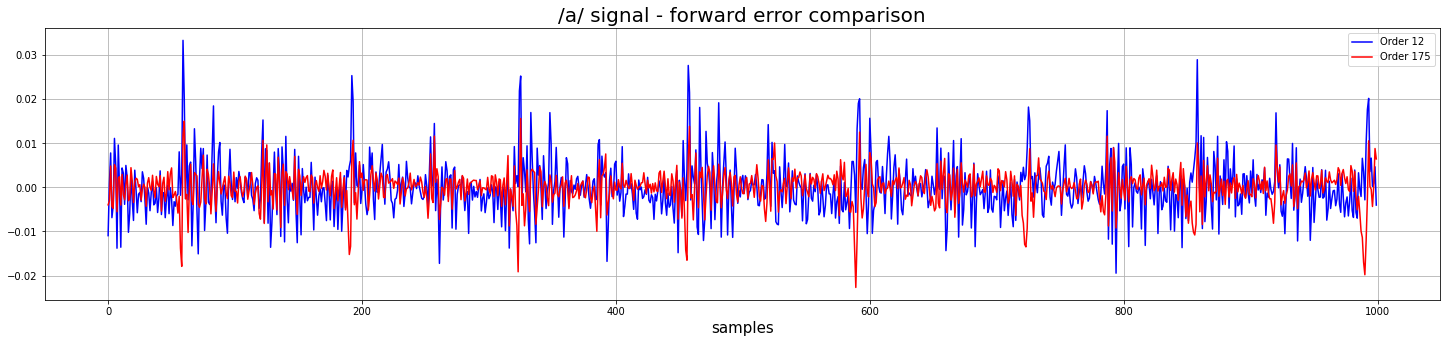

In [12]:
plt.figure(figsize=(25,5))
plt.title('/a/ signal - forward error comparison', fontsize=20)
plt.plot(e12[5000:6000], color='blue', label='Order 12')
plt.plot(e175[5000:6000], color='red', label='Order 175')
plt.grid(which='both', axis='both')
plt.xlabel('samples', fontsize=15)
plt.legend()
plt.plot();

El fenómeno mencionado anteriormente también se manifiesta en la señal de error. Se compara el caso de predicción con órdenes $M_0=12$ y $M_1=175$. Entre estos valores se encuentra uno de los picos de la autocorrelación. En el gráfico se observan picos de amplitud sobresaliente intercalados cada 135 muestras aproximadamente (valor coincidente con la distancia entre los picos en la autocorrelación). Luego, al aumentar el orden incorporando este nuevo pico en la autocorrelación, se puede observar que el error de predicción es, en general, más bajo en cuanto al valor absoluto de la amplitud de los picos mencionados.

## 3. Respuesta en frecuencia filtro de error

En este apartado se calcula $H(e^{j\omega})$ para el filtro del error de predicción $\bar{a}$. Se repite este proceso para ambas grabaciones, considerando $M=1,2,4,8,16,32,64$. Se agrega el valor $M=150$ al análisis.

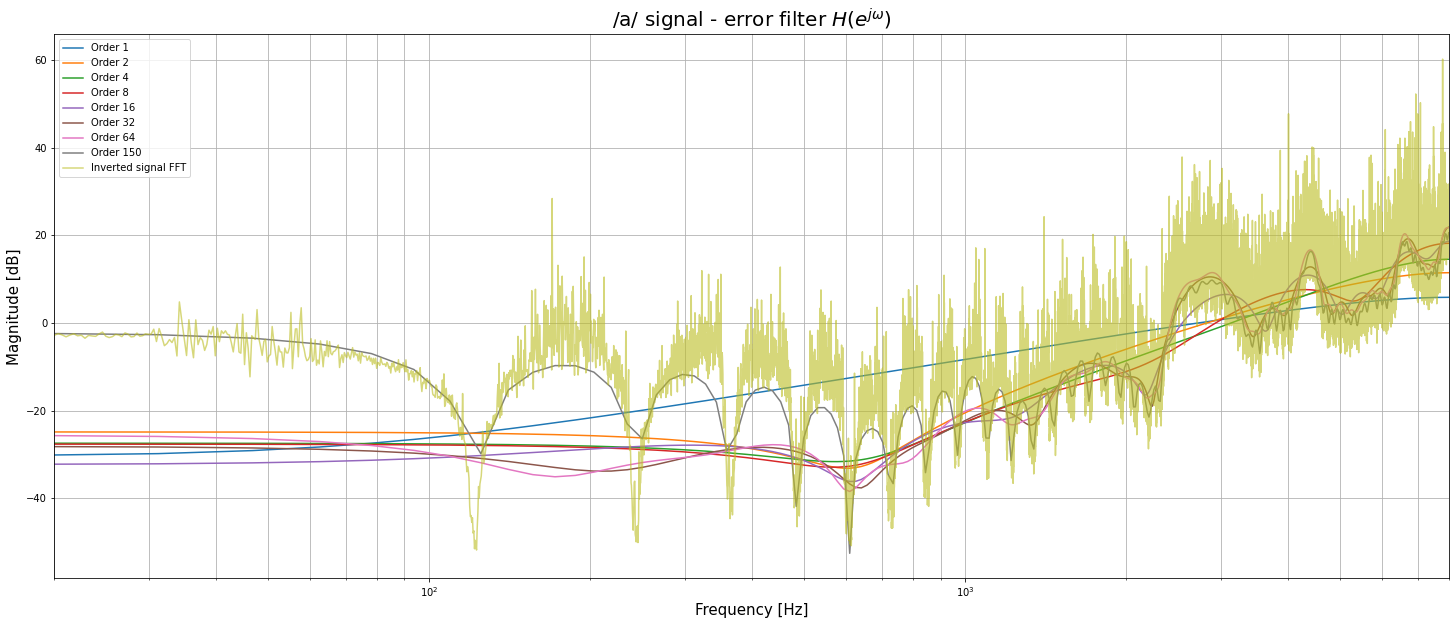

In [13]:
M = [1, 2, 4, 8, 16, 32, 64, 150]
plt.figure(figsize=(25,10))
for i in range(len(M)):
    a, _ = forward_prediction_filter(a_norm, M[i])
    a_e = np.concatenate(([1],a))
    
    # Get frequency response
    w, h = sps.freqz(b=a_e, a=1)
    x = w  * a_fs * 1.0 / (2 * np.pi)
    y = 20 * np.log10(abs(h))
    
    # Plot frequency response
    plt.semilogx(x, y, label='Order {}'.format(M[i]))

# Original signal FFT
S = np.fft.fft(a_norm)
f = np.fft.fftfreq(len(S), 1/a_fs)
plt.semilogx(f[f> 0],-20*np.log10(np.abs(S[f> 0])), label='Inverted signal FFT', alpha=0.6)

plt.legend()
plt.grid(which='both')
plt.title('/a/ signal - error filter $H(e^{j\omega}$)', fontsize=20)
plt.xlim(20,8000)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)
plt.show()

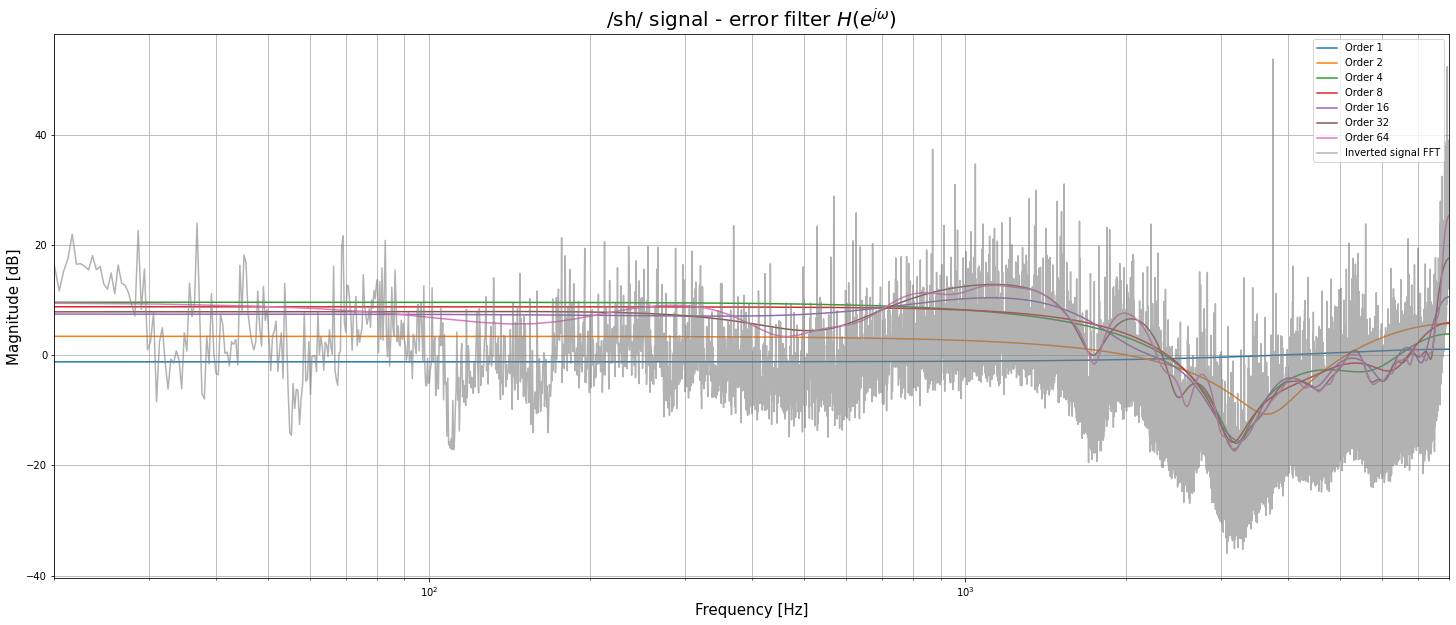

In [14]:
M = [1, 2, 4, 8, 16, 32, 64]
plt.figure(figsize=(25,10))
for i in range(len(M)):
    a, _ = forward_prediction_filter(sh_norm, M[i])
    a_e = np.concatenate(([1],a))
    
    # Get frequency response
    w, h = sps.freqz(b=a_e, a=1)
    x = w  * sh_fs * 1.0 / (2 * np.pi)
    y = 20 * np.log10(abs(h))
    
    # Plot frequency response
    plt.semilogx(x, y, label='Order {}'.format(M[i]))
    
# Original signal FFT
S = np.fft.fft(sh_norm)
f = np.fft.fftfreq(len(S), 1/sh_fs)
plt.semilogx(f[f> 0],-20*np.log10(np.abs(S[f> 0])), label='Inverted signal FFT', alpha=0.6)

plt.legend()
plt.grid(which='both')
plt.title('/sh/ signal - error filter $H(e^{j\omega}$)', fontsize=20)
plt.xlim(20,8000)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)
plt.show()

Observando los gráficos anteriores se puede ver como la $H(e^{j\omega})$ para la señal de error tiende a ser el espectro de la señal oroginal invertido. Esto se fundamenta en el concepto de que la señal ideal de error puede ser modelada como ruido blanco gaussiano, basándose en que el límite de error de predicción se encuentra en las innovaciones de la señal de entrada. Luego, si se piensa al filtro de error como la resta entre la señal original y la señal de error e igualando a una señal de ruido blanco, se obtiene que el producto entre la transformada de la señal de entrada y la función transferencia del filtro del error es igual a la transformada del ruido, que por la suposición anteriormente realizada es una constante $k$ que es proporcional a su amplitud. 

$$e^f(n)= x(n) \ast h_{error}(n) \rightarrow E^f(e^{j\omega}) = X(e^{j\omega}) \cdot H_{error}(e^{j\omega}) = k $$
$$H_{error}(e^{j\omega}) = \frac{k}{X(e^{j\omega})}  $$


Luego, se concluye que la función transferencia del error (en condiciones ideales) se corresponde con la inversa de la transformada de la señal de entrada, multiplicada por la amplitud del ruido $k$ ($k \in \mathbb{R}$).

Este efecto se ve preponderantemente en el orden $M=150$ propuesto para el análisis.

Por otro lado, también aplica lo concluído respecto al comportamiento del error MSE óptimo en función del orden. En ambos gráficos se aprecian diferencias considerables al variar el órden por encima de cada uno de los codos que presentan las señales en su error óptimo.

## 3.5 Potencia de la señal de error
Adicionalmente, se analizó el comportamiento de la señal de error para los órdenes propuestos anteriormente. Acorde a lo expuesto, debería verificarse que al aumentar el orden del filtro la señal de error debe asemejarse más a una señal de ruido blanco gaussiano incorrelacionado. A continuación se grafica el periodograma de la señal de error para ambas señales grabadas.

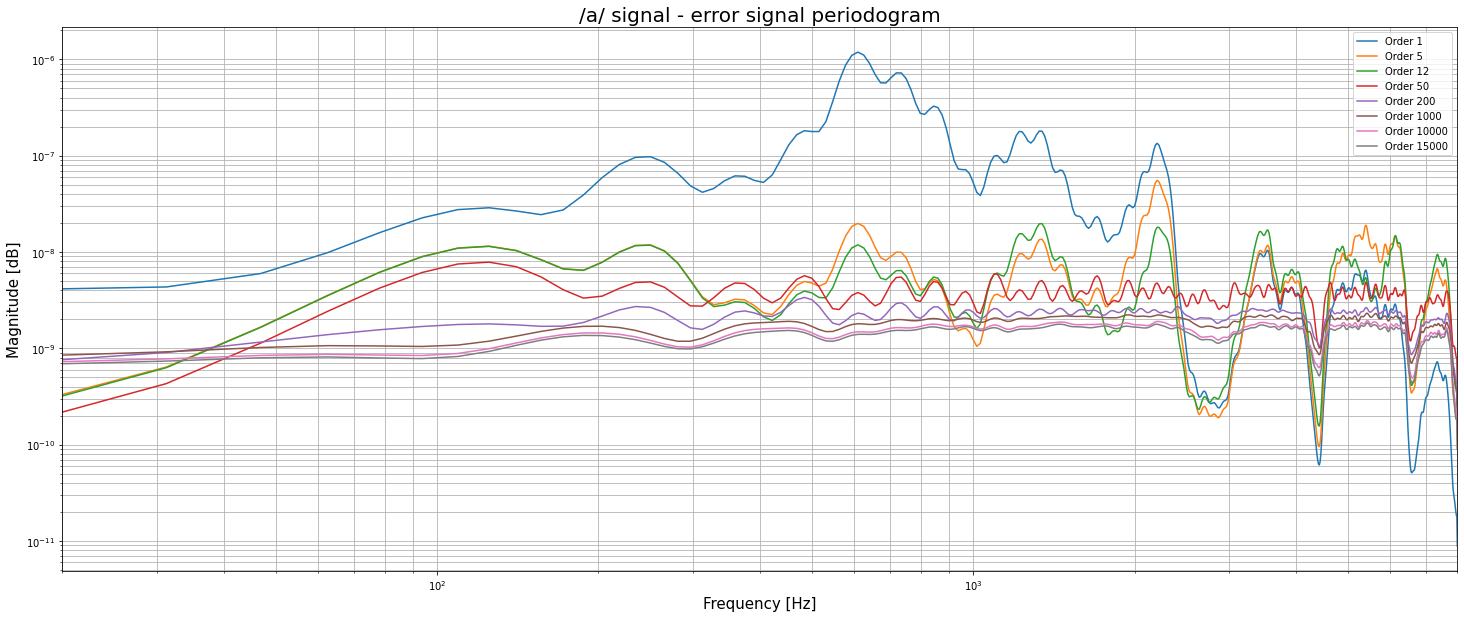

In [15]:
M = [1, 5, 12, 50, 200, 1000, 10000, 15000]
plt.figure(figsize=(25,10))
for i in range(len(M)):
    
    a, _ = forward_prediction_filter(a_norm, M[i])
    e = get_forward_error(a_norm, a)
    
    # Get signal periodogram
    f, S = sps.welch(e, fs=a_fs, window='hann', nfft=1024, noverlap=64)
    
    # Plot periodogram
    #f, S = sps.periodogram(e, fs=a_fs, window='hann', nfft=1024)
    #f, S = sps.welch(e, fs=a_fs, window='hann', nfft=1024, noverlap=64)
    plt.semilogy(f[f>0], np.abs(S[f>0]), label='Order {}'.format(M[i]))
    
plt.xscale('log')
plt.legend()
plt.grid(which='both')
plt.title('/a/ signal - error signal periodogram', fontsize=20)
plt.xlim(20,8000)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)
plt.show()

En el gráfico anterior se aprecia como al aumentar el orden del filtro, la densidad espectral de potencia de la señal de error obtenida tiende a ser plana en todo su espectro. Nuevamente, esto se condice con lo asumido anteriormente. Por otro lado, se aprecia cómo el espectro se ve poco afectado por el orden del filtro, cuando $M>200$ (es decir, por encima del segundo codo ubicado en $M=135$, siendo el error $J_o$ asintótico respecto del orden $M$).

Lo mismo ocurre con la densidad espectral de potencia de la señal de error del filtro predictor de la señal /sh/, con la diferencia de que en ese caso el error $J_o$ presenta un solo codo en $M=25$. Luego, no se observa una diferencia apreciable entre las curvas con $M>25$.

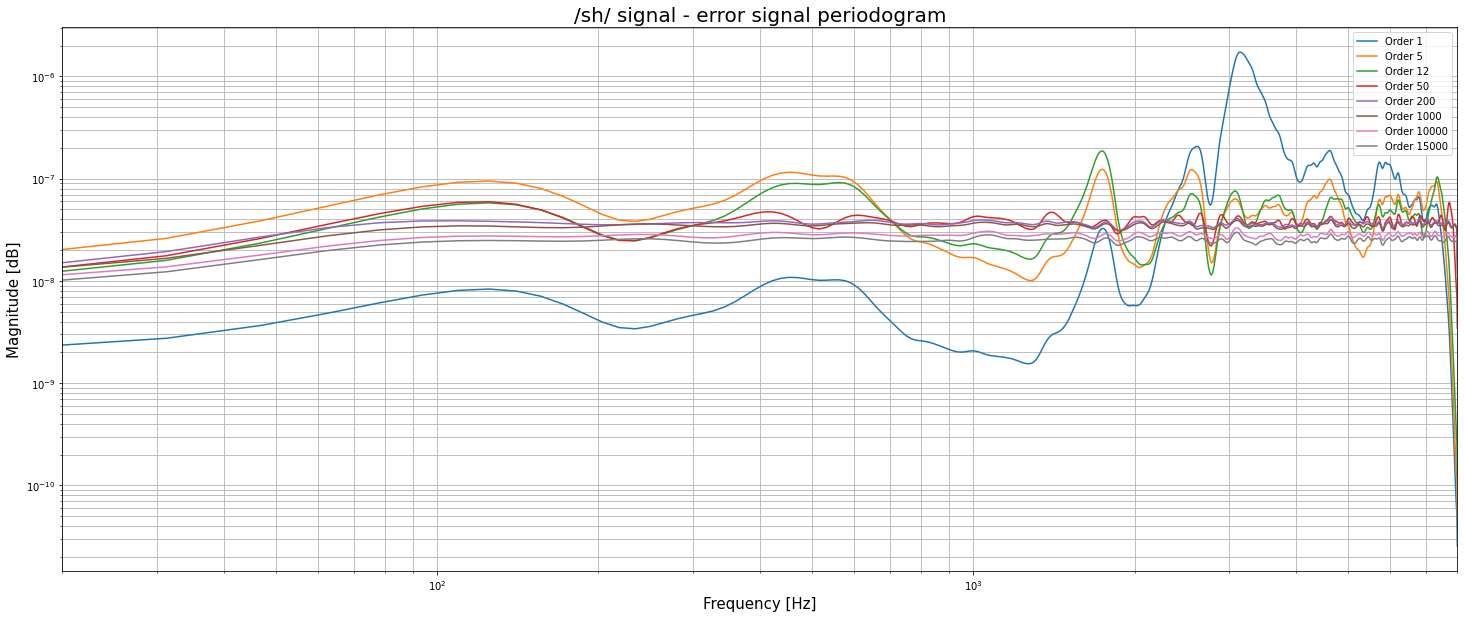

In [16]:
plt.figure(figsize=(25,10))
for i in range(len(M)):
    
    a, _ = forward_prediction_filter(sh_norm, M[i])
    e = get_forward_error(sh_norm, a)
    
    # Get signal periodogram
    f, S = sps.welch(e, fs=sh_fs, window='hann', nfft=1024, noverlap=64)

    # Plot periodogram
    plt.semilogy(f[f>0], np.abs(S[f>0]), label='Order {}'.format(M[i]))

plt.xscale('log')
plt.legend()
plt.grid(which='both')
plt.title('/sh/ signal - error signal periodogram', fontsize=20)
plt.xlim(20,8000)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)
plt.show()

# 4. Resintetizado de señal de error
Para resintetizar la señal de error de cada fonema se pide emplear un orden $M$ acorde, con la restricción de no superar el segundo codo presente en la curva de $J_o$ para la señal /a/. Dado lo expuesto hasta el momento, se decide adoptar un orden $M=25$ para resintetizar ambas señales. La justificación de esta elección radica en que adoptar ordenes mayores al del primer codo hacen que el cálculo escale más de lo que lo hace la disminución del error (sin tener en cuenta el segundo codo en /a/). Luego, se buscan optimizar recursos.

## 4.1 Fonema /a/

En primera instancia, se grafica la señal de error del filtro predictor orden $M=25$.

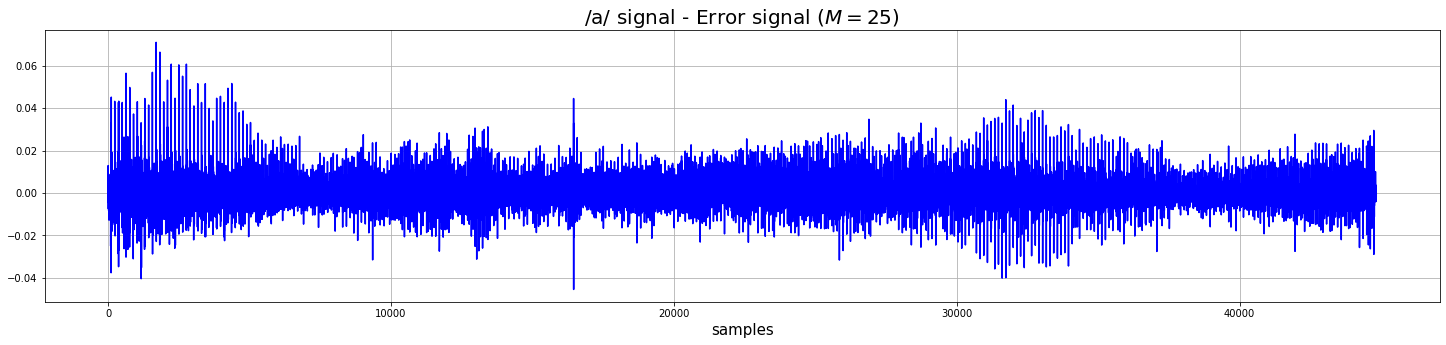

In [17]:
M = 25

# Compute filter
a_a, _ = forward_prediction_filter(a_norm, M)

# Compute error signal
a_err = get_forward_error(a_norm, a_a)[M:]

plt.figure(figsize=(25,5))
plt.grid(which='both')
plt.title(f'/a/ signal - Error signal ($M={M}$)', fontsize=20)
plt.xlabel('samples', fontsize=15)
plt.plot(a_err, color='blue')
plt.show()

Se busca resintetizar la señal de error. Para ello se proponen dos modelos distintos:
* Modelo AR
* Tren de deltas

La inclusión de la segunda opción se sustenta en la observación de la señal de error graficada anteriormente. En ella se pueden distinguir nuevamente los picos cada 130 muestras (valor coincidente con el segundo codo de $J_o$).

## 4.1.1 Modelado con AR
Para poder representar a la señal empleando un modelo AR debe observarse el comportamiento de la autocorrelación, que se grafica a continuación.

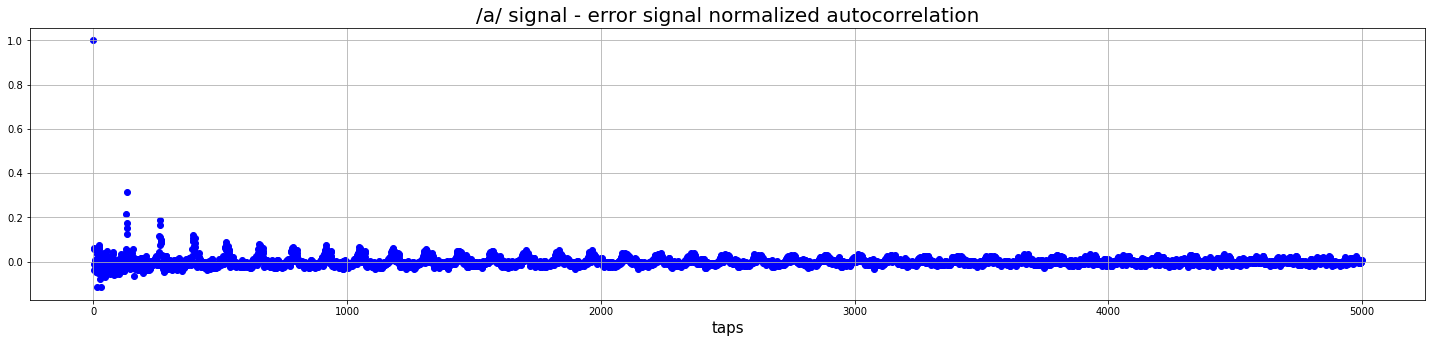

In [18]:
# Compute autocorrelation for /a/ signal.
a_err_corr =  sps.correlate(a_err, a_err, method='fft', mode='same')[len(a_err)//2:] / (len(a_err))

# Normalize autocorrelation
a_err_corr = a_err_corr[:5000] / a_err_corr[0]

# PLot autocorrelation
plt.figure(figsize=(25,5))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(a_err_corr)), a_err_corr, color='blue')
plt.title('/a/ signal - error signal normalized autocorrelation', fontsize=20)
plt.xlabel('taps', fontsize=15)
plt.show()

Ahora, se calculan los coeficientes de autocorrelación parcial $\phi_{k,k}$ resolviendo la ecuación de Yule-Walker.

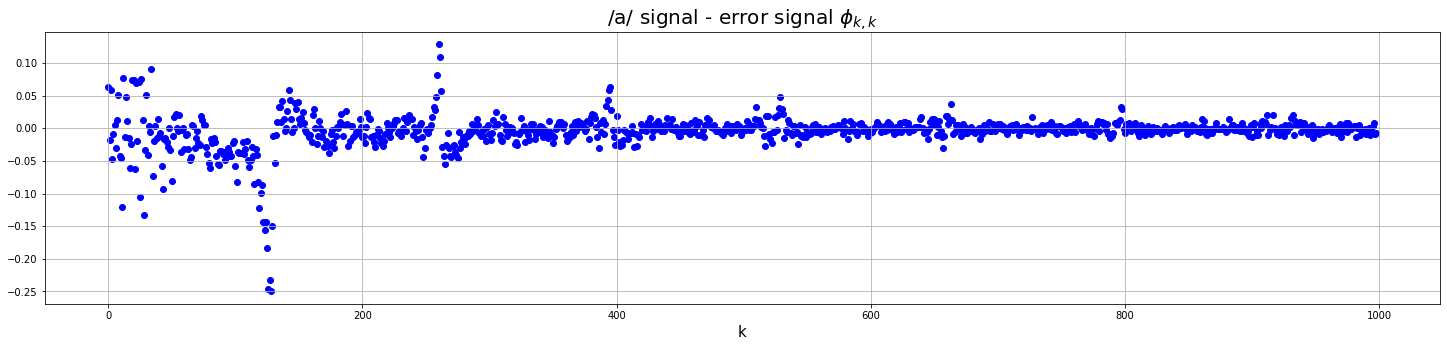

In [19]:
a_phi_kk = []

for i in range(1,1000):
    # Solve Yule-Walker equation
    a_phi = solve_toeplitz(a_err_corr[:i], a_err_corr[1:i+1])
    a_phi_kk.append(a_phi[-1])

# Print phi
plt.figure(figsize=(25,5))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(a_phi_kk)), a_phi_kk, color='blue')
plt.title('/a/ signal - error signal $\phi_{k,k}$', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.show()

Analizando el gráfico de los coeficientes de autocorrelación parcial $\phi_{k,k}$ se elige un orden 425 para el filtro autorregresivo. Luego, se estiman los coeficientes del filtro resolviendo nuevamente la ecuación de Yule-Walker y se resintetiza la señal de error. Por último, se filtra a esta señal resintetizada con el filtro inverso al del error de predicción $\bar{a}$ para obtener una estimación de la señal original.

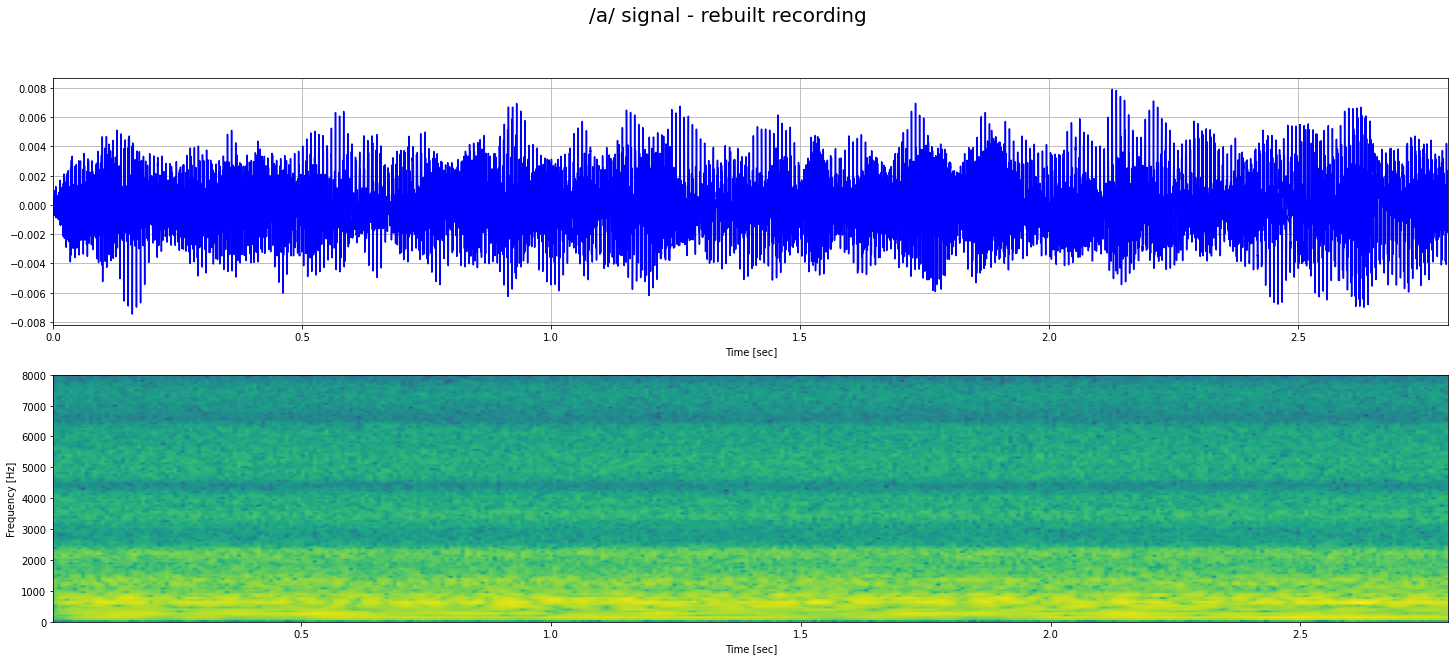

In [20]:
# AR model order
a_k = 425

# Calulate AR filter
a_ar = solve_toeplitz(a_err_corr[:a_k], a_err_corr[1:(a_k+1)])

# White noise
wn = np.random.normal(0, 1e-4, len(a_err))
a_reb_error = recursive_filter(wn, a_ar)

# Inverse filtering
a_reb_signal = sps.lfilter([1], np.concatenate(([1],a_a)), a_reb_error)

# Plot signal
print_signal(np.arange(len(a_reb_signal)) / a_fs, a_reb_signal, '/a/ signal - rebuilt recording', samplerate=a_fs, xlim=(0,len(a_reb_signal)/a_fs))

In [21]:
# Save it to wav
to_wav(a_reb_signal, '../assets/output/a_sound_rebuilt_ar.wav', a_fs, scale=0.9/np.max(a_reb_signal))

# Play rebuilt sound
print('Rebuilt /a/ sound (using AR)')
Audio('../assets/output/a_sound_rebuilt_ar.wav')

Rebuilt /a/ sound (using AR)


In [22]:
# Play original sound
print('Original /a/ sound')
Audio('../assets/a_sound.wav')

Original /a/ sound


Se comparan ambas grabaciones. La principal diferencia audible es que la señal reconstruida parece tener una distorsión semejante a un reverberador. De todas formas, se llega a identificar correctamente el fonema /a/. Respecto a sus contenidos espectrales, al generar el espectograma y compararlos lado a lado se concluye que las principales bandas de frecuencias se mantienen en la grabación reconstruida, pero se pierde cierta modulación temporal. Esto es visible en la comparación siguiente, en donde el espectrograma de la señal reconstruida es más unforme temporalmente en comparación al de la señal original.

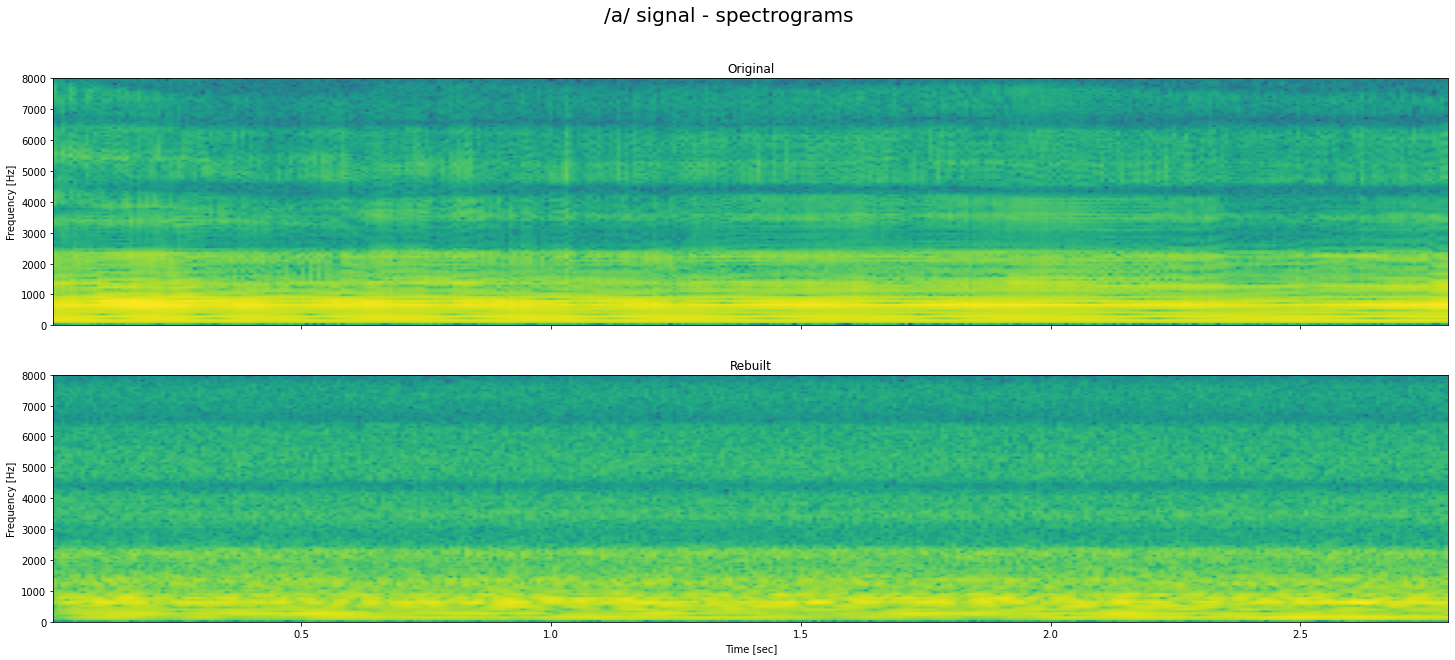

In [23]:
# Plot spectrograms
plot_spectrograms('../assets/a_sound.wav', '../assets/output/a_sound_rebuilt_ar.wav', '/a/ signal - spectrograms')

## 4.1.2 Modelado con tren de deltas
Por otro lado, se modela a la señal de error como un tren de deltas. Para estimar la frecuencia de las delta se observa en detalle la señal del filtro de error.

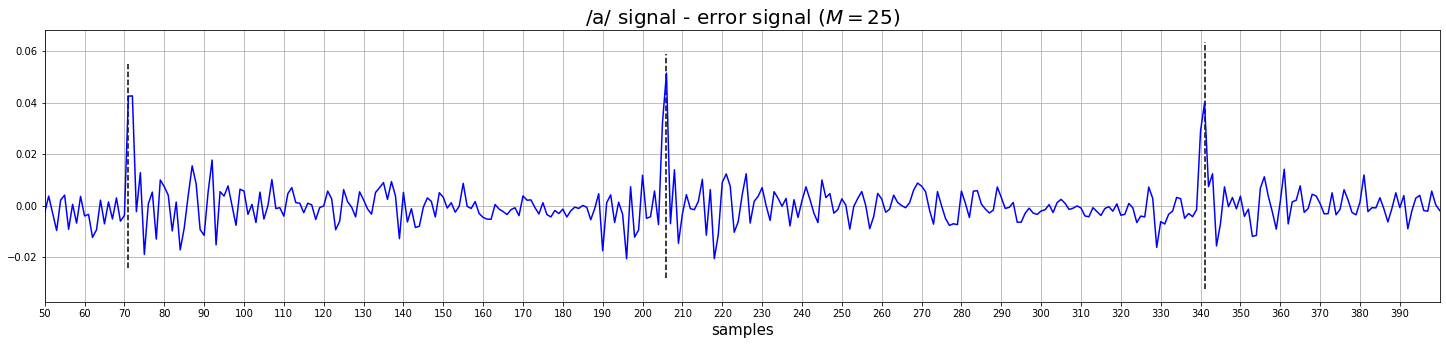

In [24]:
plt.figure(figsize=(25,5))
plt.grid(which='both')
plt.title(f'/a/ signal - error signal ($M={M}$)', fontsize=20)
plt.xlabel('samples', fontsize=15)
plt.xticks(np.arange(50,400,10))
plt.xlim(50,400)
plt.plot(a_err[3230:3640], color='blue')
plt.vlines(71,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.vlines(206,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.vlines(341,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.show()

Del gráfico anterior se desprende que hay 135 muestras entre deltas. Luego, se sintetiza la señal de error de esta forma.

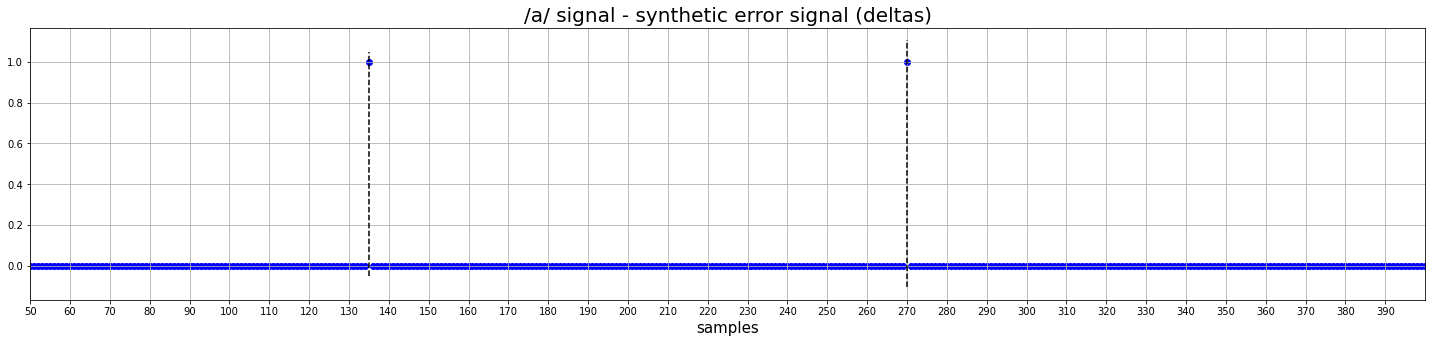

In [25]:
# Generate error signal estimation with deltas
interval = 135 # Samples
a_deltas_error = [1 if (i%interval==0) else 0 for i in range(len(a_norm))]

# Plot signals
plt.figure(figsize=(25,5))
plt.grid(which='both')
plt.title(f'/a/ signal - synthetic error signal (deltas)', fontsize=20)
plt.xlabel('samples', fontsize=15)
plt.xticks(np.arange(50,400,10))
plt.xlim(50,400)
plt.scatter(np.arange(len(a_deltas_error)), a_deltas_error, color='blue')
plt.vlines(135,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.vlines(270,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.show()

Ahora, se aplica el filtro inverso del error para obtener una estimación de la señal de voz original.

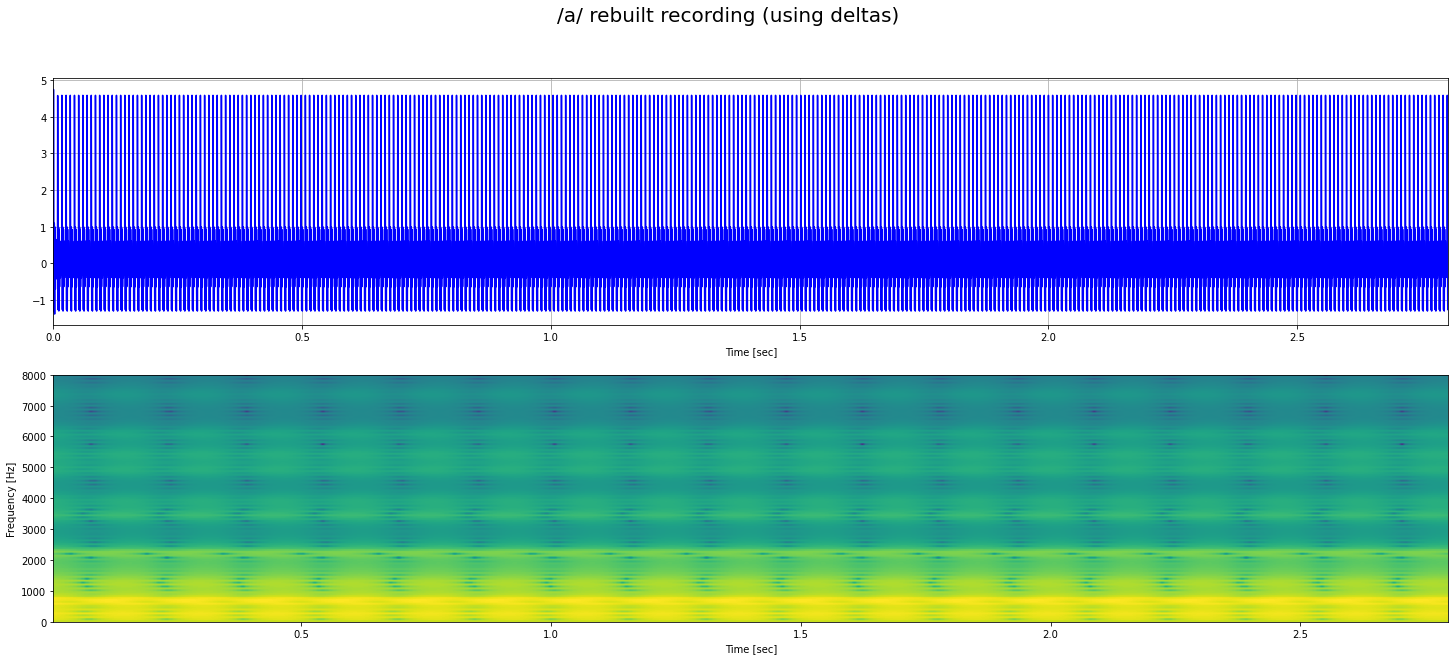

In [26]:
# Inverse filtering
a_reb_deltas_signal = sps.lfilter([1], np.concatenate(([1],a_a)), a_deltas_error)

# Plot signal
print_signal(np.arange(len(a_reb_deltas_signal)) / a_fs, a_reb_deltas_signal, '/a/ rebuilt recording (using deltas)', samplerate=a_fs, xlim=(0,len(a_reb_deltas_signal)/a_fs))

In [27]:
# Save it to wav
to_wav(a_reb_deltas_signal, '../assets/output/a_sound_rebuilt_deltas.wav', a_fs, scale=0.9/np.max(a_reb_deltas_signal))

# Play rebuilt sound
print('Rebuilt /a/ sound (using deltas)')
Audio('../assets/output/a_sound_rebuilt_deltas.wav')

Rebuilt /a/ sound (using deltas)


In [28]:
# Play original sound
print('Original /a/ sound')
Audio('../assets/a_sound.wav')

Original /a/ sound


En comparación con el resultado empleando el modelo AR, en el caso del modelado con deltas se obtiene un sonido distinto. El efecto de reverberación observado en el primer caso es reemplazado por un sonido más marcado, que al escucharlo evidencia que es sintético (es un sonido poco natural). Nuevamente se comparan los espectrogramas de la señal reconstruida y señal original. Al igual que en el caso anterior, en general se mantienen las bandas de frecuencia. En este caso se observa un efecto de modulación temporal que no está presente en la original.

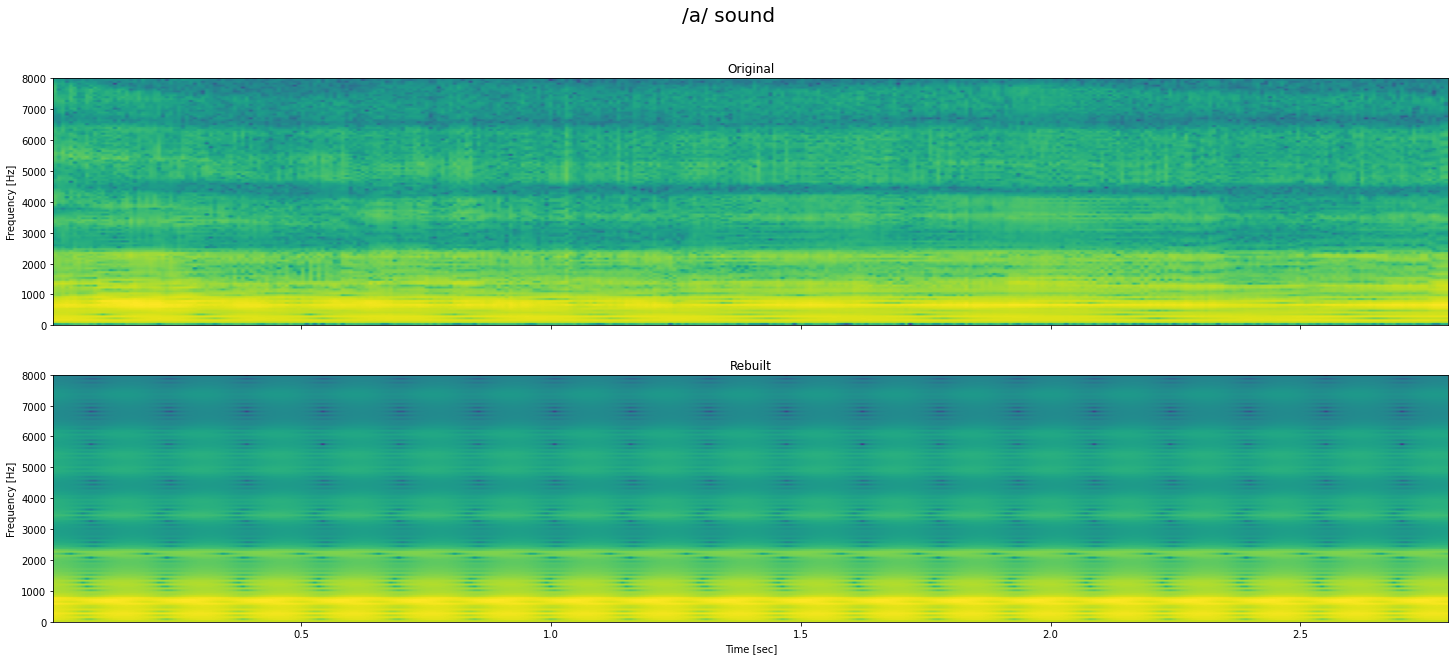

In [29]:
# Plot spectrograms
plot_spectrograms('../assets/a_sound.wav', '../assets/output/a_sound_rebuilt_deltas.wav', '/a/ sound')

## 4.2 Fonema /sh/

Se repite el procedimiento realizado con la señal /a/ para la señal /sh/.

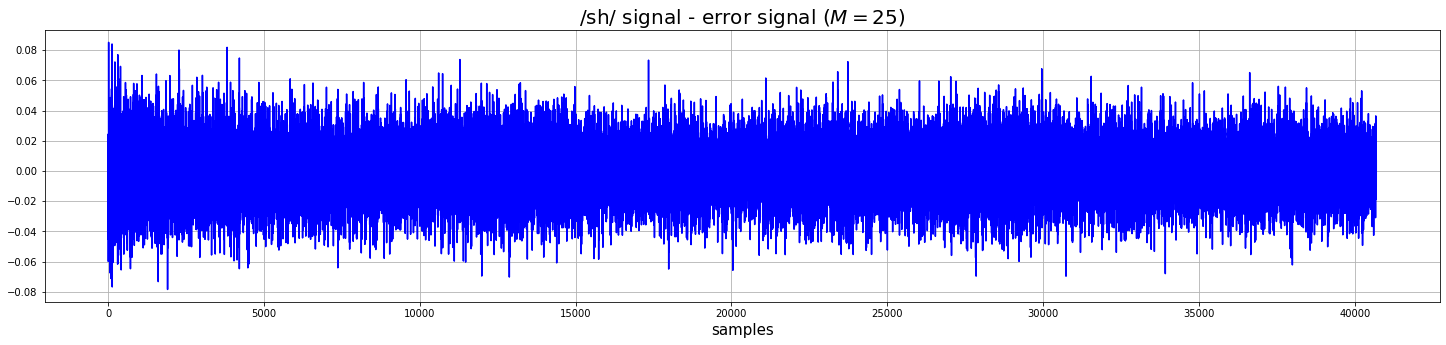

In [30]:
M = 25

# Compute filter
a_sh, _ = forward_prediction_filter(sh_norm, M)

# Compute error signal
sh_err = get_forward_error(sh_norm, a_sh)[M:]

plt.figure(figsize=(25,5))
plt.grid(which='both')
plt.title(f'/sh/ signal - error signal ($M={M}$)', fontsize=20)
plt.xlabel('samples', fontsize=15)
plt.plot(sh_err, color='blue')
plt.show()

Se modela a la señal de error previamente graficada de dos formas:
* Modelo AR
* Ruido blanco gaussiano

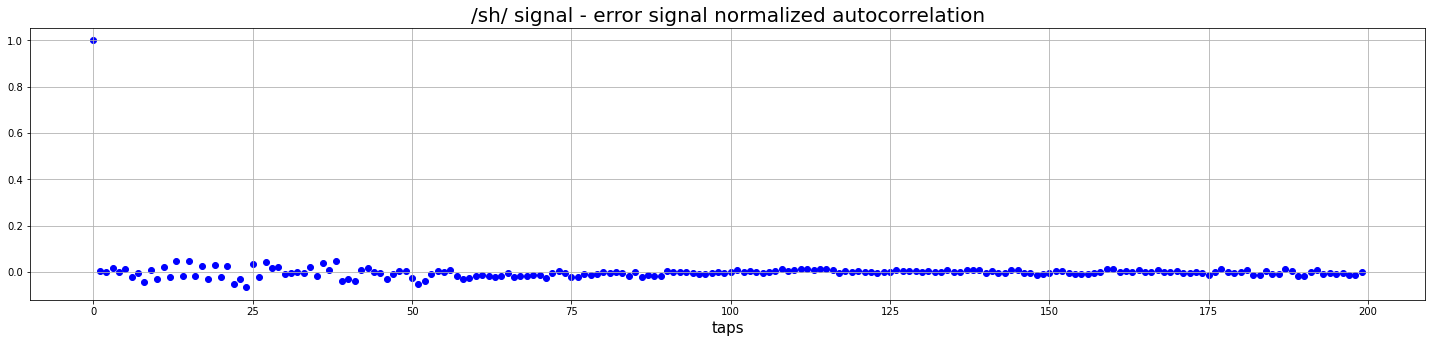

In [31]:
# Compute autocorrelation for /a/ signal.
sh_err_corr =  sps.correlate(sh_err, sh_err, method='fft', mode='same')[len(sh_err)//2:] / (len(sh_err))

# Normalize autocorrelation
sh_err_corr = sh_err_corr[:200] / sh_err_corr[0]

# PLot autocorrelation
plt.figure(figsize=(25,5))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(sh_err_corr)), sh_err_corr, color='blue')
plt.title('/sh/ signal - error signal normalized autocorrelation', fontsize=20)
plt.xlabel('taps', fontsize=15)
plt.show()

## 4.2.1 Modelado con WGN
La autocorrelación de la señal de error puede aproximarse como una delta de Dirac. Por lo tanto, es posible modelar y reconstruir la señal de error como una secuencia de ruido gaussiano de media cero y varianza unitaria. Luego, se aplica el filtro inverso del filtro del error de predicción y se analizan los resultados.

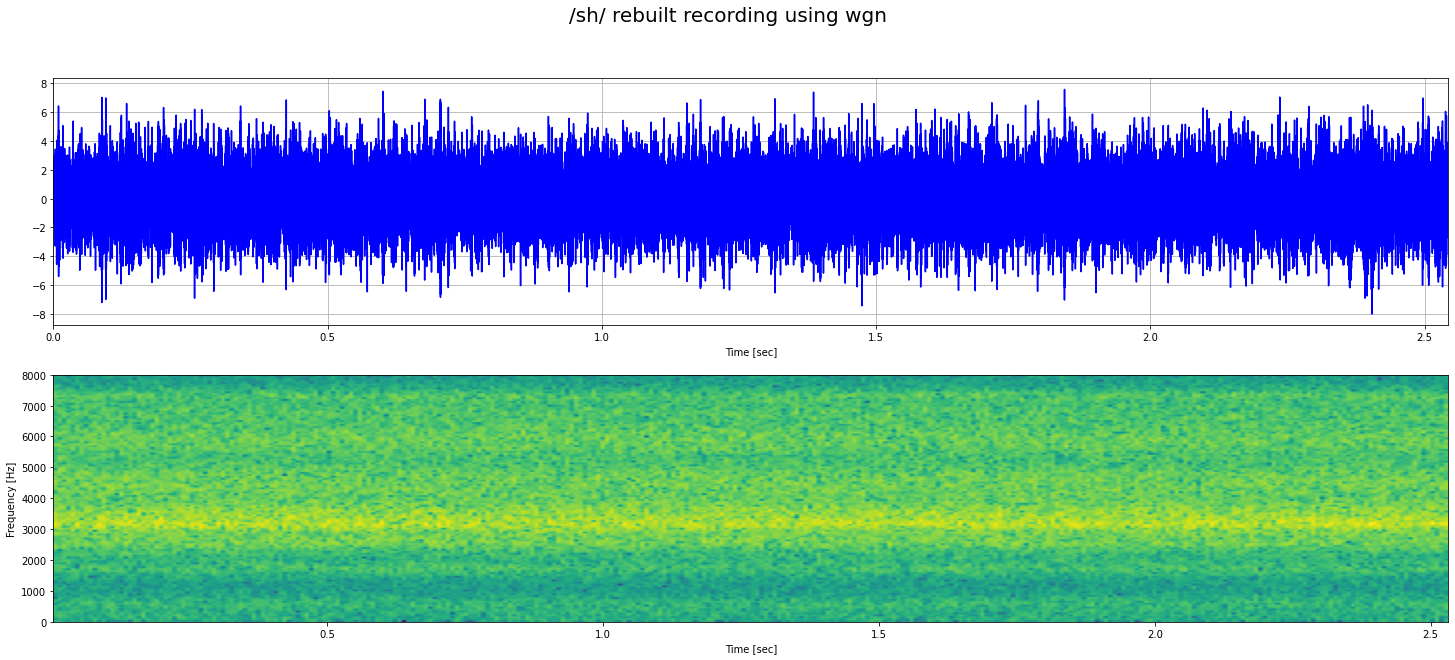

In [32]:
# White noise
sh_wn_error = np.random.normal(0, 1, len(sh_err))

# Inverse filtering
sh_wn_reb_signal = sps.lfilter([1], np.concatenate(([1],a_sh)), sh_wn_error)

# Plot signal
print_signal(np.arange(len(sh_wn_reb_signal)) / sh_fs, sh_wn_reb_signal, '/sh/ rebuilt recording using wgn', samplerate=sh_fs, xlim=(0,len(sh_wn_reb_signal)/sh_fs))

In [33]:
# Save it to wav
to_wav(sh_wn_reb_signal, '../assets/output/sh_sound_rebuilt_wgn.wav', sh_fs, scale=0.9/np.max(sh_wn_reb_signal))

# Play rebuilt sound
print('Rebuilt /sh/ sound (using wgn)')
Audio('../assets/output/sh_sound_rebuilt_wgn.wav')

Rebuilt /sh/ sound (using wgn)


In [34]:
# Play original sound
print('Original /sh/ sound')
Audio('../assets/sh_sound.wav')

Original /sh/ sound


Se compara la estimación del fonema /sh/ con la grabación original. En la reconstrucción, se aprecia un mayor ruido de fondo respecto de la original. Por último, se grafican los espectrogramas para ambas señales. En este caso, ambos espectrogramas se asemejan fuertemente. No hay diferencias apreciables.

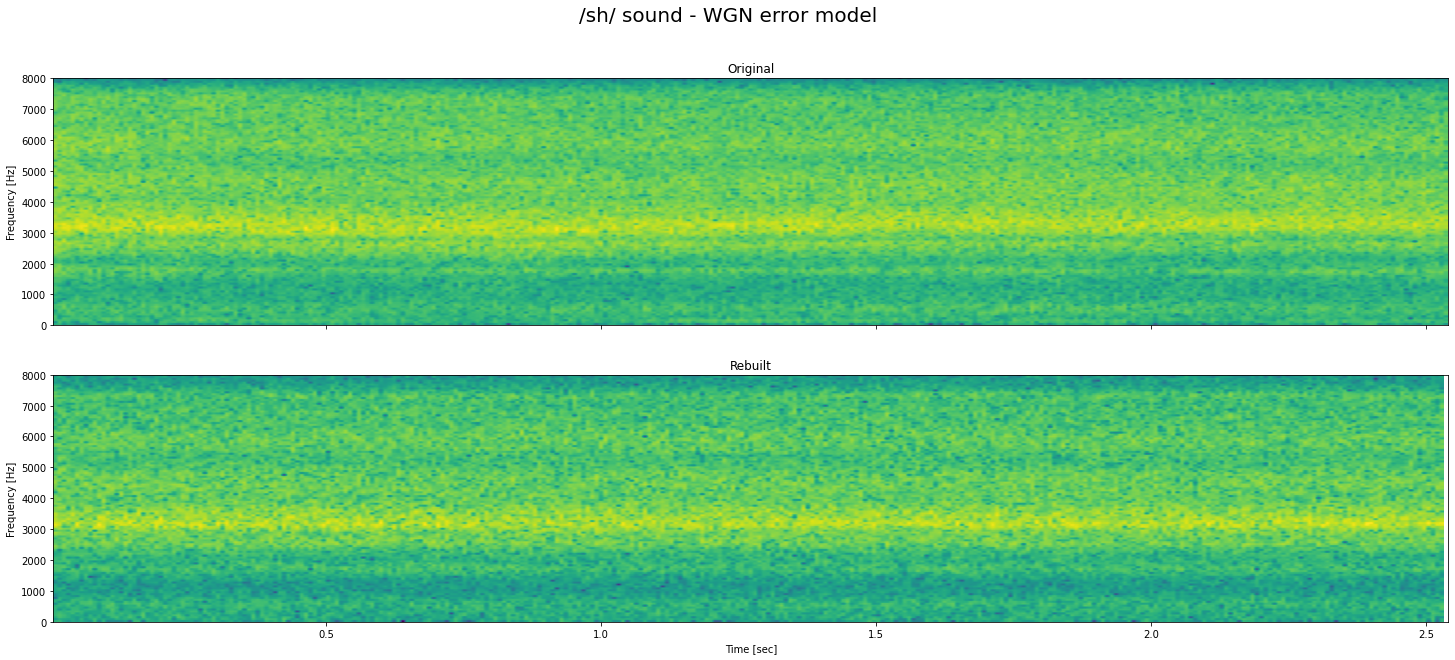

In [35]:
# Plot spectrograms
plot_spectrograms('../assets/sh_sound.wav', '../assets/output/sh_sound_rebuilt_wgn.wav', '/sh/ sound - WGN error model')

## 4.2.1 Modelado con AR

Al estimar la autocorrelación de la señal de error como una delta, se están perdiendo las correlaciones de las muestras siguientes. Aunque estas son despreciables, se busca modelar su efecto de forma tal de poder comparar con la estimación previamente realizada. Es por ello que se decide sintetizar la señal de error con un modelo AR. La forma de determinar el orden y sus parámetros es idéntica a la realizada con la señal /a/ anteriormente, comenzando por graficar los coeficientes de autocorrelación parcial $\phi_{k,k}$ para la señal de error.

In [36]:
sh_phi_kk = []

for i in range(1,1000):
    # Solve Yule-Walker equation
    sh_phi = solve_toeplitz(sh_err_corr[:i], sh_err_corr[1:i+1])
    sh_phi_kk.append(sh_phi[-1])

# Print phi
plt.figure(figsize=(25,5))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(sh_phi_kk)), sh_phi_kk, color='blue')
plt.title('/sh/ signal - error  signal $\phi_{k,k}$', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.show()

ValueError: Incompatible dimensions.

Se considera un modelo AR de orden 100.

In [ ]:
# AR model oder
sh_k = 100

# Calulate AR filter - k=30
sh_ar = solve_toeplitz(sh_err_corr[:sh_k], sh_err_corr[1:(sh_k+1)])

# White noise
wn = np.random.normal(0, 1e-4, len(sh_err))
sh_reb_error = recursive_filter(wn, sh_ar)

# Inverse filtering
sh_reb_signal = sps.lfilter([1], np.concatenate(([1],a_sh)), sh_reb_error)

# Plot signal
print_signal(np.arange(len(sh_reb_signal)) / sh_fs, sh_reb_signal, '/sh/ signal - rebuilt recording using AR', samplerate=sh_fs, xlim=(0,len(sh_reb_signal)/sh_fs))

In [ ]:
# Save it to wav
to_wav(sh_reb_signal, '../assets/output/sh_sound_rebuilt_ar.wav', sh_fs, scale=0.9/np.max(sh_reb_signal))

# Play rebuilt sound
print('Rebuilt /sh/ sound (using AR)')
Audio('../assets/output/sh_sound_rebuilt_ar.wav')

In [ ]:
# Play original sound
print('Original /sh/ sound')
Audio('../assets/sh_sound.wav')

Como se aprecia en las pistas de audio y en la comparativa de especrogramas, sintetizando a la señal de error con un modelo AR produce resultados tales que no es posible diferenciarlos respecto de la estimación con el modelo WGN.

In [ ]:
# Plot spectrograms
plot_spectrograms('../assets/sh_sound.wav', '../assets/output/sh_sound_rebuilt_ar.wav', '/sh/ sound - AR error model')

## 4.3 Conclusiones
En este apartado se analizó la reconstrucción de señales de audio a partir de sintetizar la señal de error de distintas formas. Esto constituye un método de compresión ampliamente utilizado en voz. Aunque la calidad de las señales reconstruidas no son las óptimas, se obervó que se puede comprimir la información para generar la grabación obteniendo calidades de audio decentes para la comprensión.

# 5. Análisis de señal de voz larga
Para concluir, se propone extrapolar el método de reconstrucción de señales observado en el punto 4 a una señal de voz extensa. A diferencia de las señales anteriores, esta contiene un fragmento de discurso. Este fue grabado a iguales condiciones que la de los fonemas /a/ y /sh/.

In [ ]:
# long sound
speech_fs, speech = wavfile.read('../assets/speech.wav')

# Plot signal
print_signal(np.arange(len(speech)) / speech_fs, speech, 'speech recording', samplerate=speech_fs, xlim=(0,len(speech)/speech_fs))

In [ ]:
# Play original sound
print('Original speech')
Audio('../assets/speech.wav')

Para poder llevar a cabo esta estimación, se analiza a la grabación dividiéndola en frames de $50ms$, con un overlap del 50%. Se ventanea a cada frame con una ventana del tipo coseno cuadrado. Luego, se estima el filtro del error de predicción de orden $M=12$ para cada frame. Se impone un tren de deltas de frecuencia $f_\delta=160Hz$ como señal de error y se le aplica el filtro inverso de $\bar{a}$. De esta forma, se obtiene una estimación del frame. Por último, se suman todas las estimaciones de los frames, respetando su posición original y teniendo en cuenta el overlap. Ventanear con coseno cuadrado y aplicando un desfasaje del 50% genera que al sumar fragmentos con overlap la suma de las ventanas sea 1. De esta forma, no se introduce distorsión por ventana en la señal resultante.

In [ ]:
# Window length
w_len = int(0.05 * speech_fs) #int(0.05 * speech_fs)

# Window overlap
w_overlap = 0.5

# Filter order
M = 12

# Speech length
N = len(speech)

# Delta generator
interval = 100 # Samples
speech_deltas = [1 if (i%interval==0) else 0 for i in range(N)]

# Output
rebuilt_speech = np.zeros(N)

# Window calculation
window = sps.cosine(w_len)**2 # sps.hann(w_len)

for i in range(0, N-w_len, int(w_len * (1-w_overlap))):
    # Get speech frame
    chunk = speech[i:i+w_len] * window
    chunk = chunk - np.mean(chunk)
    delta_chunk = speech_deltas[i:i+w_len] * window
    
    # Compute filter
    a_speech, _ = forward_prediction_filter(chunk, M)
    
    # Rebuild chunk
    rebuilt_chunk = sps.lfilter([1], np.concatenate(([1],a_speech)), delta_chunk)
    
    # Add to output signal
    rebuilt_speech[i:i+w_len] += (rebuilt_chunk)

# Save to wav
to_wav(rebuilt_speech, '../assets/output/speech_rebuilt.wav', speech_fs, scale=0.9/np.max(rebuilt_speech));

In [ ]:
print('Rebuilt speech')
Audio('../assets/output/speech_rebuilt.wav')

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(np.arange(len(rebuilt_speech))/speech_fs, rebuilt_speech*0.9/np.max(rebuilt_speech)*32267, label='rebuilt', color='blue')
plt.plot(np.arange(len(rebuilt_speech))/speech_fs, speech, label='original', color='red')
plt.title('Speech signal', fontsize=20)
plt.xlabel('Time [sec]', fontsize=15)
plt.legend()
plt.grid(which='both', axis='both')

Comparando la señal reconstruida con la original, se nota una clara distorsión. El efecto es el mismo que el apreciado al reconstruir la grabación del fonema /a/: se escucha un sonido más marcado y evidentemente sintético (poco natural, casi "robótico" y poco agradable). De todas formas, llegan a apreciarse las modulaciones que hacen a los fonemas y se puede entender el mensaje grabado.